In [10]:
import pandas as pd

# === Config ===
# Path to your DB search PSM file (genus-level analysis)
psm_path = "wetransfer_db-resultaten-en-metagenomics-db_2025-05-19_1335/Peaks_export/YA_RZ_GW_SHMX_DB_analysis_genus_db/DB search psm.csv"

# Recommended threshold for high confidence PSMs
default_threshold = 30  # corresponds to p = 0.001

def filter_psms_by_score(filepath, score_threshold=default_threshold):
    """
    Load the PSM table and filter based on -10lgP threshold.

    Args:
        filepath (str): Path to the CSV file.
        score_threshold (float): Minimum -10lgP score to retain a match.

    Returns:
        pd.DataFrame: Filtered PSM DataFrame.
    """
    print(f"🔍 Loading PSM data from: {filepath}")
    df = pd.read_csv(filepath)

    # Sanity check
    if "-10lgP" not in df.columns:
        raise ValueError("Column '-10lgP' not found in the input file.")

    print(f"📊 Total matches before filtering: {len(df)}")

    # Apply threshold
    filtered_df = df[df["-10lgP"] >= score_threshold].reset_index(drop=True)

    print(f"✅ Matches after filtering (≥ {score_threshold}): {len(filtered_df)}")
    return filtered_df

# === Run the filter with the default threshold
filtered_psms = filter_psms_by_score(psm_path)


🔍 Loading PSM data from: wetransfer_db-resultaten-en-metagenomics-db_2025-05-19_1335/Peaks_export/YA_RZ_GW_SHMX_DB_analysis_genus_db/DB search psm.csv
📊 Total matches before filtering: 6335
✅ Matches after filtering (≥ 30): 6335


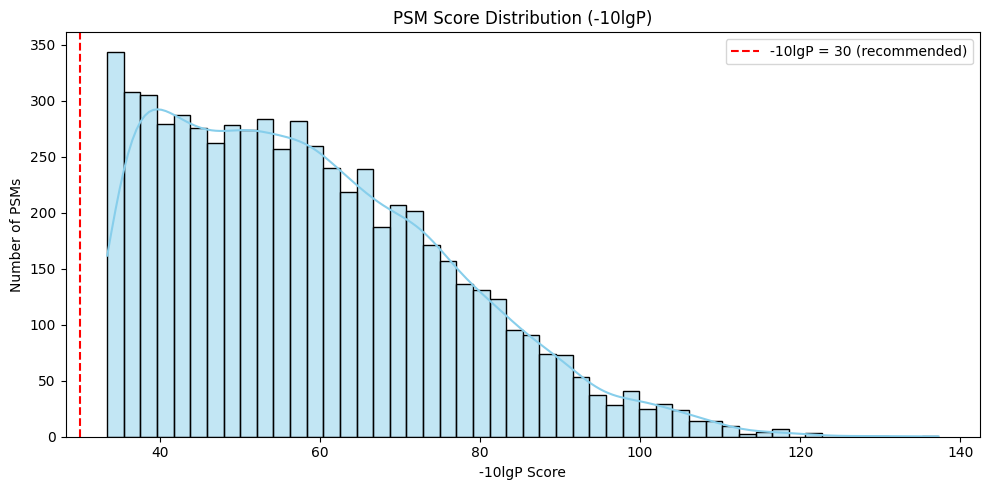

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distribution(df, score_column="-10lgP", bins=50):
    """
    Plot distribution of PSM scores.

    Args:
        df (pd.DataFrame): PSM DataFrame.
        score_column (str): Column with the PSM score (usually -10lgP).
        bins (int): Number of histogram bins.
    """
    if score_column not in df.columns:
        raise ValueError(f"'{score_column}' not found in DataFrame.")

    plt.figure(figsize=(10, 5))
    sns.histplot(df[score_column], bins=bins, kde=True, color="skyblue")
    plt.axvline(30, color="red", linestyle="--", label="-10lgP = 30 (recommended)")
    plt.title("PSM Score Distribution (-10lgP)")
    plt.xlabel("-10lgP Score")
    plt.ylabel("Number of PSMs")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Plot for your filtered or unfiltered DataFrame
plot_score_distribution(filtered_psms)  # or replace with full df if desired

In [12]:
import pandas as pd

# === Load the PEAKS DB Search PSM CSV ===
psm_path = "wetransfer_db-resultaten-en-metagenomics-db_2025-05-19_1335/Peaks_export/YA_RZ_GW_SHMX_DB_analysis_genus_db/DB search psm.csv"
df = pd.read_csv(psm_path)

# === Basic peptide count metrics ===
total_psms = len(df)
unique_peptides = df["Peptide"].nunique()

print(f"🔢 Total PSMs: {total_psms}")
print(f"🧬 Unique peptides: {unique_peptides}")

# === Optional: peptide counts per protein accession ===
peptides_per_protein = df.groupby("Accession")["Peptide"].nunique().sort_values(ascending=False)
print("\n📦 Peptide counts per protein (top 10):")
print(peptides_per_protein.head(10))


🔢 Total PSMs: 6335
🧬 Unique peptides: 4235

📦 Peptide counts per protein (top 10):
Accession
A0A369XUD3|A0A369XUD3_9PROT                                23
A0A369XNQ7|A0A369XNQ7_9PROT                                23
W6M2M4|W6M2M4_9GAMM                                        22
W6M0L7|W6M0L7_9GAMM                                        21
W6MA33|W6MA33_9GAMM                                        21
A0A6A7RN62|A0A6A7RN62_9PROT:A0A011PVG8|A0A011PVG8_9PROT    17
A0A3E1DIP8|A0A3E1DIP8_9PROT                                16
A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT    16
W6M8F3|W6M8F3_9GAMM                                        16
W6MDZ3|W6MDZ3_9GAMM                                        15
Name: Peptide, dtype: int64


In [13]:
import pandas as pd
from Bio import SeqIO
from IPython.display import display
import re

# === Load your PSM file ===
psm_path = "wetransfer_db-resultaten-en-metagenomics-db_2025-05-19_1335/Peaks_export/YA_RZ_GW_SHMX_DB_analysis_genus_db/DB search psm.csv"
df = pd.read_csv(psm_path)

# === Parse your FASTA file to get accession-to-organism map ===
fasta_path = r"fasta_proteomes/session_2025-05-12_00-46-46/custom_database_genus.fasta"
accession_to_taxa = {}

for record in SeqIO.parse(fasta_path, "fasta"):
    header = record.description
    match = re.search(r"OS=(.+?)(?: OX=| GN=| PE=| SV=|$)", header)
    if match:
        taxon = match.group(1).strip()
    else:
        taxon = "Unknown"
    
    for acc in record.id.split("|"):
        accession_to_taxa[acc.strip()] = taxon

# === Function to extract taxa for each accession entry ===
def extract_taxa(accession_str):
    if pd.isna(accession_str):
        return ""
    taxa_found = []
    seen = set()
    for block in accession_str.split(":"):
        for acc in block.split("|"):
            acc = acc.strip()
            taxon = accession_to_taxa.get(acc, "NA")
            if taxon not in seen:
                seen.add(taxon)
                taxa_found.append(taxon)
    return ", ".join(taxa_found)

# === Construct new dataframe with taxa column ===
df_with_taxa = df[["Peptide", "Accession"]].copy()
df_with_taxa["Taxon names"] = df_with_taxa["Accession"].apply(extract_taxa)

# === Display output cleanly ===
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

display(df_with_taxa.head(15))


,Peptide,Accession,Taxon names
0,LGEHNIDVLEGNEQFINAAK,NaN,
1,LGEHNIDVLEGNEQFINAAK,NaN,
2,LGEHNIDVLEGNEQFINAAK,NaN,
3,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus"
4,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus"
5,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis
6,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis
7,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis
8,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis
9,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis


In [16]:
import pandas as pd
from Bio import Entrez
import time
from IPython.display import display

# Email required for NCBI Entrez access
Entrez.email = "your_email@example.com"

# === Function: Get Taxon ID from a single scientific name ===
def get_taxid_from_name(name):
    try:
        handle = Entrez.esearch(db="taxonomy", term=name.strip(), retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        if records["IdList"]:
            return records["IdList"][0]
        else:
            return "NA"
    except Exception as e:
        print(f"❌ Error for '{name}': {e}")
        return "NA"

# === Caching mechanism to speed up repeated queries ===
taxid_cache = {}

# === Vectorized function to extract all taxon IDs per row ===
def extract_taxids(taxon_str):
    if pd.isna(taxon_str):
        return ""
    names = [n.strip() for n in taxon_str.split(",") if n.strip()]  # strip whitespace
    taxids = []
    for name in names:
        if name in taxid_cache:
            taxids.append(taxid_cache[name])
        else:
            taxid = get_taxid_from_name(name)
            taxid_cache[name] = taxid
            taxids.append(taxid)
            time.sleep(0.35)  # respect NCBI rate limit
    return ", ".join(taxids)

# === Apply the function ===
df_with_taxa["Taxon IDs"] = df_with_taxa["Taxon names"].apply(extract_taxids)

# === Preview final result ===
display(df_with_taxa[["Peptide", "Accession", "Taxon names", "Taxon IDs"]].head(15))

,Peptide,Accession,Taxon names,Taxon IDs
0,LGEHNIDVLEGNEQFINAAK,NaN,,
1,LGEHNIDVLEGNEQFINAAK,NaN,,
2,LGEHNIDVLEGNEQFINAAK,NaN,,
3,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383"
4,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383"
5,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160
6,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160
7,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160
8,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160
9,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160


In [43]:
import requests
import pandas as pd

# === Define corrected UniPept LCA fetch function ===
def get_lca_and_rank(taxon_ids_str):
    try:
        # Parse and clean taxon ID string
        taxon_ids = [tid.strip().strip("\"'") for tid in taxon_ids_str.split(",") if tid.strip()]
        
        # Skip empty input
        if not taxon_ids:
            return pd.Series(["NA", "NA"])

        # If only one ID, treat that taxon itself as the LCA
        if len(taxon_ids) == 1:
            return pd.Series([taxon_ids[0], "exact match"])

        # Build the UniPept API URL
        params = "&".join([f"input[]={tid}" for tid in taxon_ids])
        url = f"https://api.unipept.ugent.be/api/v2/taxa2lca.json?{params}&extra=true"
        
        # Query the API
        response = requests.get(url)
        response.raise_for_status()
        result = response.json()

        # Parse taxon name and rank, based on type
        if isinstance(result, dict):  # Correct for multi-input cases
            return pd.Series([result.get("taxon_name", "NA"), result.get("taxon_rank", "NA")])
        elif isinstance(result, list) and result:
            return pd.Series([result[0].get("taxon_name", "NA"), result[0].get("taxon_rank", "NA")])
        else:
            return pd.Series(["NA", "NA"])

    except Exception as e:
        print(f"❌ Error retrieving LCA for taxon IDs {taxon_ids}: {e}")
        return pd.Series(["NA", "NA"])

# === Apply function to dataframe ===
df_with_lca = df_with_taxa.copy()
df_with_lca[["lca", "lca rank"]] = df_with_lca["Taxon IDs"].dropna().apply(get_lca_and_rank)

# === Show preview ===
display(df_with_lca[["Peptide", "Accession", "Taxon names", "Taxon IDs", "lca", "lca rank"]].head(15))



,Peptide,Accession,Taxon names,Taxon IDs,lca,lca rank
0,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
1,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
2,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
3,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383",Candidatus Accumulibacter,genus
4,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383",Candidatus Accumulibacter,genus
5,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,327160,exact match
6,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,327160,exact match
7,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,327160,exact match
8,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,327160,exact match
9,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,327160,exact match


In [55]:
# Update LCA name for rows with a single taxon ID (skip rows with ',' or empty/NA)
def update_lca_name_if_single(row):
    taxid = row.get("Taxon IDs", "")
    if isinstance(taxid, str) and "," not in taxid and taxid.strip() and taxid.strip().upper() != "NA":
        return row.get("Taxon names", row["lca"])  # use taxon name if available
    return row["lca"]  # keep existing lca for multiple IDs

# Apply to df_with_lca
df_with_lca["lca"] = df_with_lca.apply(update_lca_name_if_single, axis=1)
display(df_with_lca[["Peptide", "Taxon names", "Taxon IDs", "lca", "lca rank"]].head(15))

,Peptide,Taxon names,Taxon IDs,lca,lca rank
0,LGEHNIDVLEGNEQFINAAK,,,NA,NA
1,LGEHNIDVLEGNEQFINAAK,,,NA,NA
2,LGEHNIDVLEGNEQFINAAK,,,NA,NA
3,KVQAAQYVASHPGEVC(+57.02)PAK,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383",Candidatus Accumulibacter,genus
4,KVQAAQYVASHPGEVC(+57.02)PAK,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383",Candidatus Accumulibacter,genus
5,YGVGANYANGPINVDLVYQGR,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,exact match
6,YGVGANYANGPINVDLVYQGR,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,exact match
7,YGVGANYANGPINVDLVYQGR,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,exact match
8,YGVGANYANGPINVDLVYQGR,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,exact match
9,YGVGANYANGPINVDLVYQGR,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,exact match


In [57]:
import requests
import pandas as pd

# Make a copy
df_with_final_ranks = df_with_lca.copy()

# Function to fetch rank from UniPept taxa2tree
def fetch_rank_from_taxa2tree(taxon_id):
    try:
        # Validate input
        if not taxon_id or not taxon_id.strip().isdigit():
            raise ValueError("Invalid taxon ID")

        url = "https://api.unipept.ugent.be/api/v2/taxa2tree.json"
        params = {"input[]": taxon_id}
        response = requests.get(url, params=params)
        response.raise_for_status()
        result = response.json()

        # Recursively search tree for matching taxon ID
        def find_node_rank(node):
            if isinstance(node, dict):
                if node.get("id") == int(taxon_id):
                    return node.get("rank", "NA")
                for child in node.get("children", []):
                    rank = find_node_rank(child)
                    if rank:
                        return rank
            return None

        return find_node_rank(result) or "NA"

    except Exception as e:
        print(f"❌ Error retrieving rank for taxon ID {taxon_id!r}: {e}")
        return "NA"

# Update only valid single-ID rows
def update_rank_if_single(row):
    taxid = row.get("Taxon IDs", "").strip()
    # Only apply if it's a single, valid numeric ID
    if isinstance(taxid, str) and "," not in taxid and taxid.isdigit():
        return fetch_rank_from_taxa2tree(taxid)
    return row["lca rank"]  # Keep existing value (already filled or NA)

# Apply
df_with_final_ranks["lca rank"] = df_with_final_ranks.apply(update_rank_if_single, axis=1)

# Preview
display(df_with_final_ranks[["Peptide", "Accession", "Taxon names", "Taxon IDs", "lca", "lca rank"]].head(15))




,Peptide,Accession,Taxon names,Taxon IDs,lca,lca rank
0,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
1,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
2,LGEHNIDVLEGNEQFINAAK,NaN,,,NA,NA
3,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383",Candidatus Accumulibacter,genus
4,KVQAAQYVASHPGEVC(+57.02)PAK,A0A011PKS5|A0A011PKS5_9PROT:A0A935PZZ1|A0A935PZZ1_9PROT:A0A369XKK9|A0A369XKK9_9PROT:A0A080MBD7|A0A080MBD7_9PROT,"Candidatus Accumulibacter appositus, Candidatus Accumulibacter proximus, Candidatus Accumulibacter phosphatis, Candidatus Accumulibacter cognatus","1454003, 2954385, 327160, 2954383",Candidatus Accumulibacter,genus
5,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,species
6,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,species
7,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,species
8,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,species
9,YGVGANYANGPINVDLVYQGR,A0A6A7RR07|A0A6A7RR07_9PROT:A0A369XSR1|A0A369XSR1_9PROT,Candidatus Accumulibacter phosphatis,327160,Candidatus Accumulibacter phosphatis,species


In [ ]:
# Count how many rows have a non-empty, valid Taxon ID
has_taxon_id = df_with_final_ranks["Taxon IDs"].apply(lambda x: isinstance(x, str) and x.strip() != "" and x.strip().upper() != "NA")
n_with_taxon_id = has_taxon_id.sum()

# Count how many rows have a valid (non-NA) lca rank
has_lca_rank = df_with_final_ranks["lca rank"].apply(lambda x: isinstance(x, str) and x.strip().upper() != "NA")
n_with_lca_rank = has_lca_rank.sum()

# Total number of rows
total_rows = len(df_with_final_ranks)

# Display summary
print(f"Taxonomic summary:")
print(f"- Total rows: {total_rows}")
print(f"- Rows with Taxon ID: {n_with_taxon_id}")
print(f"- Rows with LCA rank: {n_with_lca_rank}")
print(f"- % with Taxon ID: {n_with_taxon_id / total_rows:.2%}")
print(f"- % with LCA rank: {n_with_lca_rank / total_rows:.2%}")


📊 Taxonomic summary:
- Total rows: 6335
- Rows with Taxon ID: 6103
- Rows with LCA rank: 6127
- % with Taxon ID: 96.34%
- % with LCA rank: 96.72%


In [ ]:
# Define the rank levels you want to inspect
ranks_of_interest = ["strain", "species", "genus", "family"]

# Count how many rows (PSMs) fall under each rank
rank_counts = df_with_final_ranks["lca rank"].value_counts()

# Extract only the ranks you're interested in
psm_counts_per_rank = {rank: rank_counts.get(rank, 0) for rank in ranks_of_interest}

# Print a summary
print("Number of PSMs per taxonomic rank:")
for rank, count in psm_counts_per_rank.items():
    print(f"- {rank.title()}: {count} PSMs")

📊 Number of PSMs per taxonomic rank:
- Strain: 666 PSMs
- Species: 3173 PSMs
- Genus: 1638 PSMs
- Family: 0 PSMs


C:\Temp\ipykernel_9692\1537326249.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


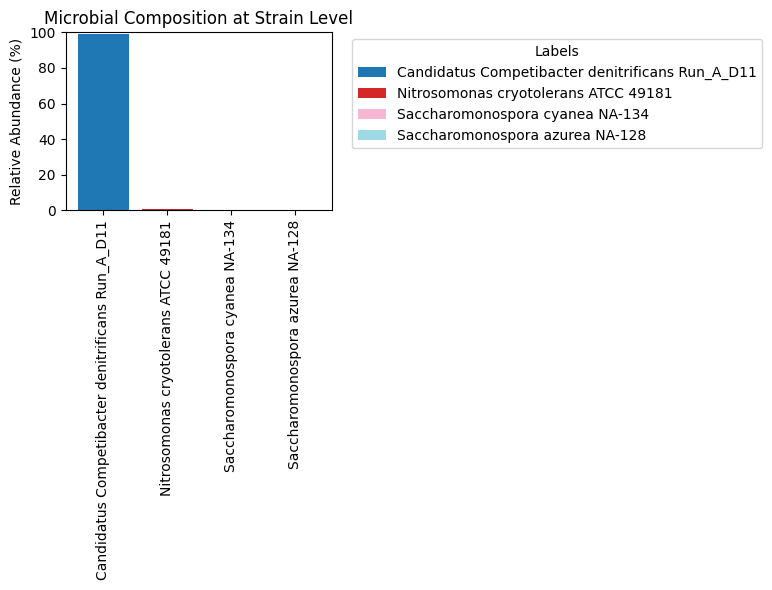

C:\Temp\ipykernel_9692\1537326249.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))
C:\Temp\ipykernel_9692\1537326249.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


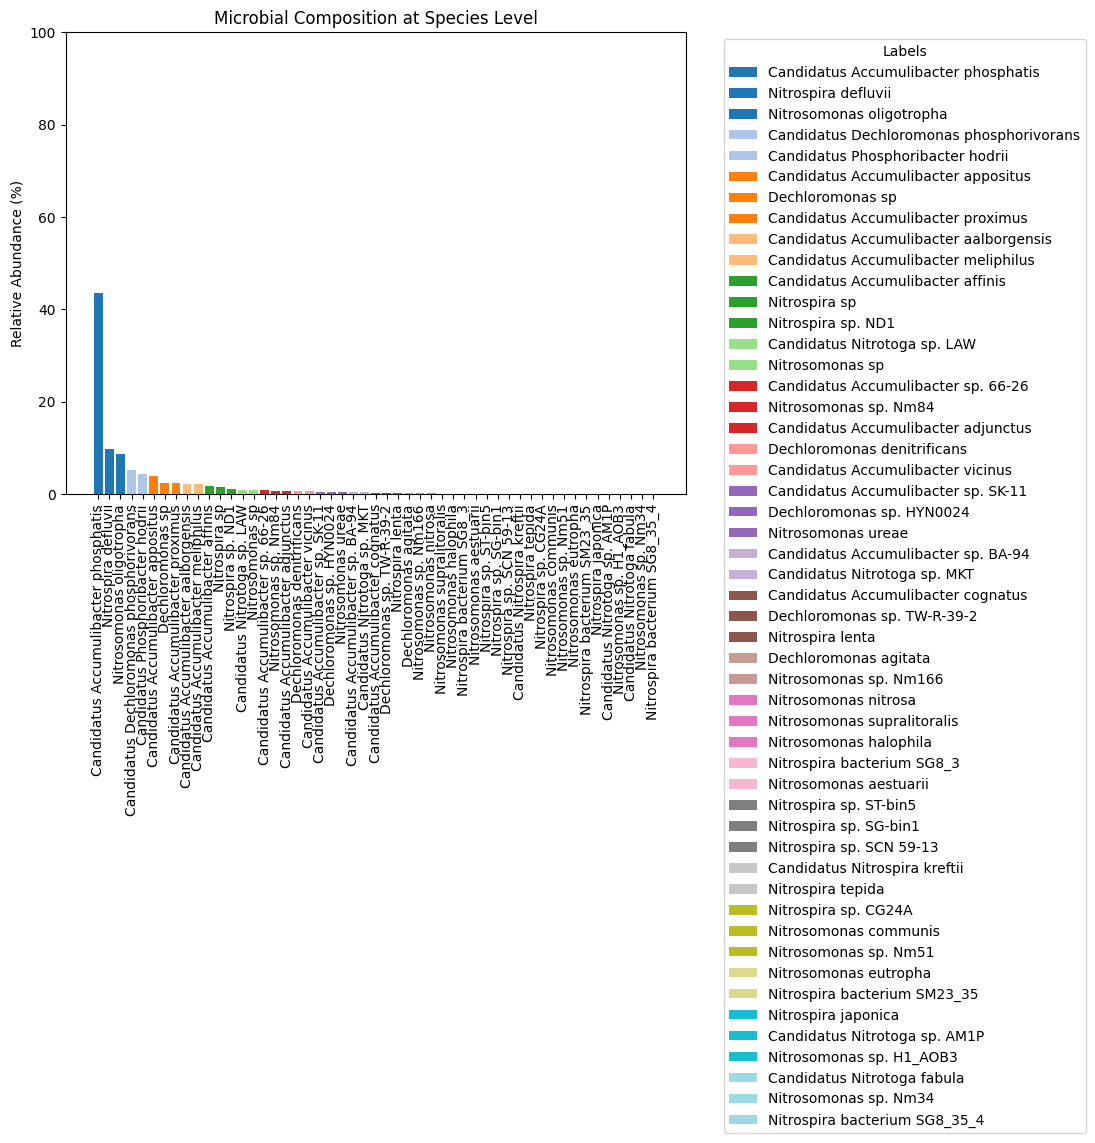

C:\Temp\ipykernel_9692\1537326249.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(rel_abundance))


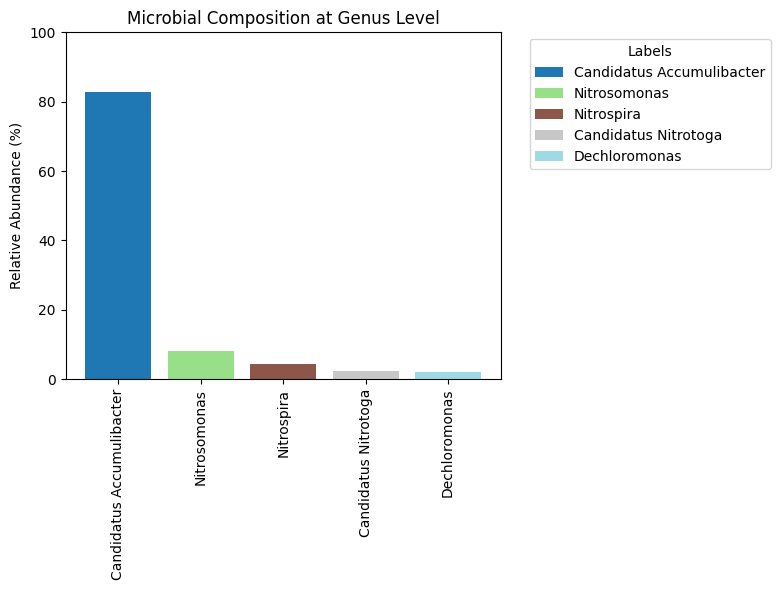

⚠️ No data for rank: family


In [62]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Ranks to visualize
ranks_to_plot = ["strain", "species", "genus", "family"]

for rank in ranks_to_plot:
    # Filter PSMs for this rank
    rank_df = df_with_final_ranks[df_with_final_ranks["lca rank"] == rank]

    if rank_df.empty:
        print(f"⚠️ No data for rank: {rank}")
        continue

    # Count and normalize taxa
    taxon_counts = rank_df["lca"].value_counts()
    rel_abundance = (taxon_counts / taxon_counts.sum()) * 100
    rel_abundance = rel_abundance.sort_values(ascending=False)

    # Generate unique colors for each bar
    cmap = cm.get_cmap('tab20', len(rel_abundance))
    colors = [cmap(i) for i in range(len(rel_abundance))]

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(rel_abundance.index, rel_abundance.values, color=colors)

    # Plot formatting
    plt.xticks(rotation=90)
    plt.ylabel("Relative Abundance (%)")
    plt.title(f"Microbial Composition at {rank.title()} Level")
    plt.ylim(0, 100)

    # Add legend
    plt.legend(bars, rel_abundance.index, title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()




### Comparison of Taxonomic Profiles: De Novo vs. PSM-Based

Interestingly, the microbial composition based on matched peptide spectrum matches (PSMs) revealed **more species** than the earlier de novo peptide-based analysis, yet **fewer genera**.

This likely reflects the impact of the **custom protein database filtering strategy**. The database was constructed by selecting proteins based on their genus-level annotations, which limits the number of genera detectable post-database. However, within each retained genus, the FASTA headers often still contain **species-level annotations**, allowing finer taxonomic resolution during downstream mapping.

In contrast, the de novo-based approach (e.g., via UniPept) likely explored a **broader range of genera** — including low-abundance or low-confidence matches — resulting in **greater genus-level diversity** but less certainty at finer resolutions.

Thus, the observed difference suggests that PSM-based profiles are **more taxonomically precise** (especially at the species level) but **constrained by the original database scope**, particularly at higher taxonomic ranks.

For future iterations, using a broader taxonomic filter (e.g., including families or all genera above a certain confidence) may help preserve community diversity while retaining annotation depth.
